In [2]:
from pathlib import Path
from datetime import datetime
import math
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import geopandas as gpd
import contextily as cx
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import transform
from pyproj import CRS, pyproj

In [3]:
inside_ltn_locations = [
    "Colombia Rd/Gossett Street",
    "Calvert Ave/Boundary Street",
    "Squirries St/Gosset St",
    ]
boundary_ltn_locations = [
    "Paradise Row/Bethnal Green Rd",
    "Parmiter St/ Cambridge Heath Road",
    "Warner Place/Hackney Rd",
    "Queensbridge Rd/Hackney Rd",
    "Bethnal Green Rd/ Brick Lane",
    "Buckfast St/Bethnal Green Rd",
    ]
ltn_locations = inside_ltn_locations + boundary_ltn_locations

In [4]:
def process(df, year):
    """ Function to process yeach yearly data to get values of interest for each month"""
    # Find first row
    first_col = df.iloc[:, 0]
    column_row_index = first_col[first_col == "Site no"].index.tolist()[0]
    # Find last column
    column_row = df.iloc[column_row_index, :]
    column_end = column_row.to_list().index(f"Dec-{str(year)[2:]}")

    columns = df.iloc[column_row_index]
    df.columns = columns
    df = df.iloc[column_row_index+1:, 1:column_end+1]
    
    # Remove and rename some columns
    df = df.rename(columns={'Location': 'location'})
    if 'Grid squaresX' in df.columns:
        df = df.rename(columns={'Grid squaresX': 'grid_squaresX', 'Grid squaresY': 'grid_squaresY'})
    elif 'Grid square\nX\n(m)' in df.columns:
        df = df.rename(columns={'Grid square\nX\n(m)': 'grid_squaresX', 'Grid square\nY\n(m)': 'grid_squaresY'})
    df = df.drop(columns=['Site Type'])
    if math.nan in df.columns:
        df = df.drop(columns=[math.nan])
    if 'Valid data\ncapture' in df.columns:
        df = df.drop(columns=['Valid data\ncapture'])
    elif 'Valid data\ncapture (%)' in df.columns:
        df = df.drop(columns=['Valid data\ncapture (%)'])

    # Flatten months to inddex
    df = df.set_index(['location', 'grid_squaresX', 'grid_squaresY']).stack().reset_index()
    df.columns = ['location', 'grid_squaresX', 'grid_squaresY', 'month', 'aq']
    df = df[['month', 'location', 'grid_squaresX', 'grid_squaresY', 'aq']]

    # Convert 'month' to a datetime object and create 'utctimestamp'
    df['utctimestamp'] = df['month'].apply(lambda x: datetime.strptime(x, '%b-%y'))
    df = df.sort_values(by='utctimestamp')
    df['period'] = df['utctimestamp'].apply(lambda x: 'before' if x < datetime(2021, 7, 1) else 'after')
    # Original test periods
    # df['test-period'] = df['utctimestamp'].apply(
    #     lambda x: 'before-period' if datetime(2019, 1, 1) <= x <= datetime(2019, 7, 31) else
    #               'after-period' if datetime(2022, 1, 1) <= x <= datetime(2022, 7, 31) else None
    # )
    df['test_period'] = df['utctimestamp'].apply(
        lambda x: 'before' if datetime(2018, 1, 1) <= x <= datetime(2019, 12, 31) else
                  'after' if datetime(2023, 1, 1) <= x <= datetime(2024, 12, 31) else None
    )

    # replace 'missing values' with NaN
    df['aq'] = df['aq'].apply(lambda x: float(x) if pd.api.types.is_number(x) or x.replace('.', '', 1).isdigit() else math.nan)

    locations_to_remove = ["At the entrance of MOT station", "At the exit of MOT station", "Millwall Park- North Greenwich Bowls Club (Co-location site)", "Millwall Park- North Greenwich Bowls Club(Co-location site)"]
    df = df[~df['location'].isin(locations_to_remove)]
    df['location'] = df['location'].replace('Bethnal Grn Rd/ Brick Lane', 'Bethnal Green Rd/ Brick Lane')

    return df

In [5]:
""" First have to open the `Tube_network_monthly_results` file
    Second add an Average column for some of the years for which it is missing
    Third make format the Average and adhusted average coumns to have 2 decimal digits
    Fourth save the file as a collection of yearly csv files (do not check to add the tab name into the csv file)
"""

path_to_data = Path("../../data/Tube_network_monthly_results/new/")
dfs = []
for year in range(2015, 2024 + 1):
    file_path = path_to_data.joinpath(f"{year}-Table 1.csv")
    df = pd.read_csv(file_path)
    df = process(df, year=year)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)
df
df.to_csv(path_to_data.joinpath("air_quality_v4.csv"), index=False)

In [6]:
sorted(df['location'].unique())

['Ackroyd Drive',
 'Admirals Way',
 'Augusta St/Giraud St',
 'Ben Johnson Road',
 'Bethnal Green Rd/ Brick Lane',
 'Blair Street (End of Street)',
 'Bonner Road',
 "Bow Common Lane/St Paul's Way",
 'Bow Rd /Glebe Terrace',
 'Bow Rd/Alfred St',
 'Brick Lane/Princelet St',
 'Brodlove Lane',
 'Bromley High Street/ St Leonards',
 'Bromley High Street/ St leonards',
 'Buckfast St/Bethnal Green Rd',
 'Calvert Ave/Boundary Street',
 'Cartwright Street',
 'Cascades, Westferry Road',
 'Cavell St/Stepney Way',
 'Chrisp Street/E India Dock Road ',
 'Colombia Rd/Gossett Street',
 'Commercial St/Calvin St',
 'Dellow St/The Highway',
 'Devas Street /Devons road',
 'Devons Road / Campbell Road ',
 'Dod St/Burdett Rd',
 'Dolphin Lane',
 'Fairfield Road/Tredegar Road ',
 'Fieldgate Street',
 'Finnis St/Three Colts Lane',
 'Ford Close/Roman Rd',
 'Globe Rd/Mile End Rd',
 'Grove Rd/Old Ford Rd',
 'Hale Street',
 'Hannibal Rd/Mile End Rd',
 'Harford St/Mile End Rd',
 'Hatfield Terrace/Fairfield Road',
 'J

['Ackroyd Drive', 'Admirals Way', 'Augusta St/Giraud St', 'Ben Johnson Road', 'Bethnal Green Rd/ Brick Lane', 'Blair Street (End of Street)', 'Bonner Road', "Bow Common Lane/St Paul's Way", 'Bow Rd /Glebe Terrace', 'Bow Rd/Alfred St', 'Brick Lane/Princelet St', 'Brodlove Lane', 'Bromley High Street/ St Leonards', 'Bromley High Street/ St leonards', 'Buckfast St/Bethnal Green Rd', 'Calvert Ave/Boundary Street', 'Cartwright Street', 'Cascades, Westferry Road', 'Cavell St/Stepney Way', 'Chrisp Street/E India Dock Road ', 'Colombia Rd/Gossett Street', 'Commercial St/Calvin St', 'Dellow St/The Highway', 'Devas Street /Devons road', 'Devons Road / Campbell Road ', 'Dod St/Burdett Rd', 'Dolphin Lane', 'Fairfield Road/Tredegar Road ', 'Fieldgate Street', 'Finnis St/Three Colts Lane', 'Ford Close/Roman Rd', 'Globe Rd/Mile End Rd', 'Grove Rd/Old Ford Rd', 'Hale Street', 'Hannibal Rd/Mile End Rd', 'Harford St/Mile End Rd', 'Hatfield Terrace/Fairfield Road', 'John Smith Mews', 'Jubilee Street/Comm

/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_1631/3784337655.py:63: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  ax.legend(loc='upper left', fontsize=22)


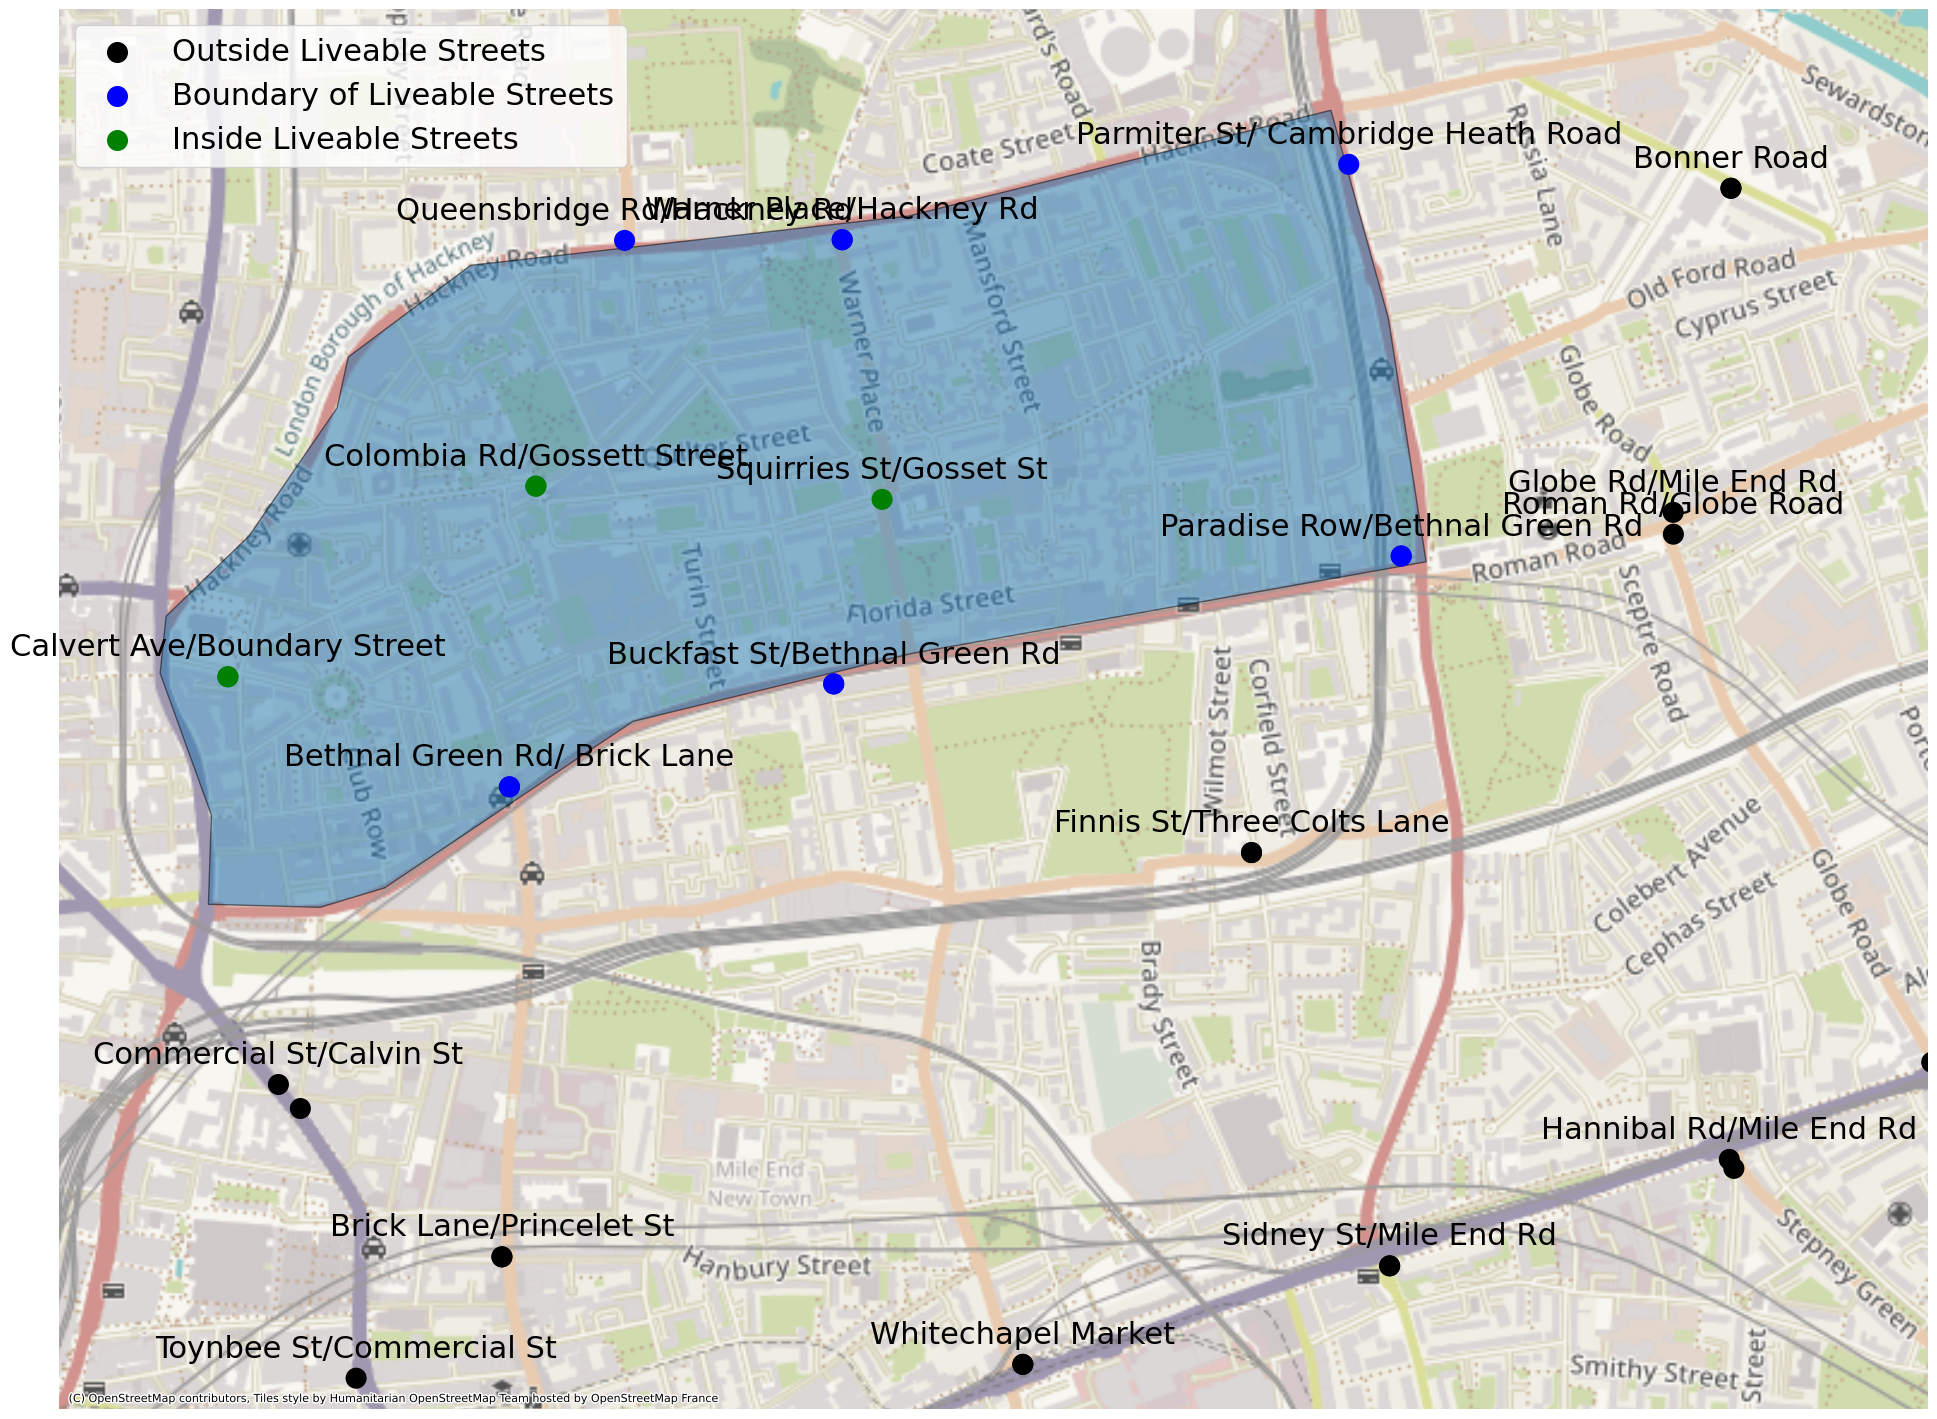

In [25]:
# Plot LTN

# by human hand
ltn_borders_list = [
    (51.532572, -0.057133), (51.531395, -0.064693), (51.530846, -0.072525), (51.529827, -0.074711), (51.529258, -0.074914), (51.527835, -0.076487),
    (51.526941, -0.077971), (51.526306, -0.078077), (51.524729, -0.077161),
    (51.523735, -0.077214), (51.523701, -0.075217), (51.523917, -0.074064), (51.525771, -0.069619), (51.526525, -0.064638),
    (51.527547, -0.055430), (51.530254, -0.056104)]
ltn_borders_list = [(lon, lat) for lat, lon in ltn_borders_list] #NOTE: swap lat and lon
ltn_borders_list = [Point(lat, lon) for lat, lon in ltn_borders_list]

# epsg 3857 is Mercator, ltn_df is the solid polygon of the ltn
ltn_df = gpd.GeoDataFrame(geometry=[Polygon(ltn_borders_list)], crs=CRS.from_epsg(4326)).to_crs(epsg=3857)

# Plot the air measurements locations
df_geo = df.groupby(['location', 'grid_squaresX', 'grid_squaresY']).agg({'aq': ['mean', 'std']}).reset_index()
print(sorted(df_geo['location'].unique()))

df_geo['is_in_ltn'] = df_geo['location'].apply(lambda loc: loc in inside_ltn_locations)
df_geo['is_boundary_ltn'] = df_geo['location'].apply(lambda loc: loc in boundary_ltn_locations)
geometry = gpd.points_from_xy(df_geo['grid_squaresX'], df_geo['grid_squaresY'])
air_locations_df = gpd.GeoDataFrame(df_geo, geometry=geometry, crs=CRS.from_epsg(27700)).to_crs(epsg=3857)  # Assuming British National Grid (EPSG:27700)

fig, ax = plt.subplots(1, 1, figsize=(20, 20))

# Clip the map to the bounding box of the LTN polygon
margin = 1000
minx, miny, maxx, maxy = ltn_df.total_bounds

ltn_df.plot(ax=ax, alpha=0.5, edgecolor="k", label='LTN polygon')
# ltn_borders_df.plot(ax=ax, alpha=1., edgecolor="k", markersize=300, label='LTN vertices')

# Set color based on location type
air_locations_df['color'] = air_locations_df.apply(
    lambda row: 'green' if row['is_in_ltn'].all() else ('blue' if row['is_boundary_ltn'].all() else 'black'), axis=1
)
# Add a label column based on 'is_in_ltn' and 'is_boundary_ltn'
air_locations_df['label'] = air_locations_df.apply(
    lambda row: 'Inside Liveable Streets' if row['is_in_ltn'].all() else ('Boundary of Liveable Streets' if row['is_boundary_ltn'].all() else 'Outside Liveable Streets'), axis=1
)

# Plot the air measurement locations with the assigned colors
# Get unique labels and their corresponding colors
unique_labels = air_locations_df[['label', 'color']].drop_duplicates()
for label, color in zip(unique_labels['label'], unique_labels['color']):
    ax.scatter([], [], color=color, label=label, s=200)

# Plot the air measurement locations with the assigned colors
air_locations_df.plot(ax=ax, markersize=200, color=air_locations_df['color'], alpha=1.0)

# Add location names next to each marker
location_names_printed = []
for x, y, label in zip(air_locations_df.geometry.x, air_locations_df.geometry.y, air_locations_df['location']):
    if label in location_names_printed:
        continue
    location_names_printed.append(label)
    if minx <= x <= maxx + margin and miny - margin <= y <= maxy:
        ax.text(x, y + 30, label, fontsize=22, ha='center', va='bottom', color='black')
ax.set_xlim(minx - 200, maxx + margin)
ax.set_ylim(miny - margin, maxy + 200)


ax.legend(loc='upper left', fontsize=22)

cx.add_basemap(ax)
ax.axis("off")
fig.tight_layout()
fig.savefig('./N02_locations.jpg', dpi=100, bbox_inches='tight')

In [14]:
from scipy.stats import ttest_ind
import numpy as np
# Create dataframe for the test period
df_test = df[~df['test_period'].isna()]

# Create aggreagate

th_df = df_test.query('`location` not in @ltn_locations').groupby(['month', 'utctimestamp', 'period', 'test_period']).mean().reset_index()
th_df['location'] = 'Tower Hamlets'
th_df['grid_squaresX'], th_df['grid_squaresY'] = math.nan, math.nan
th_df = th_df[df_test.columns]
th_df = th_df.sort_values(by='utctimestamp')

ltn_df = df_test.query('`location` in @ltn_locations').groupby(['month', 'utctimestamp', 'period', 'test_period']).mean().reset_index()
ltn_df['location'] = 'LTN'
ltn_df['grid_squaresX'], ltn_df['grid_squaresY'] = math.nan, math.nan
ltn_df = ltn_df[df_test.columns]
ltn_df = ltn_df.sort_values(by='utctimestamp')

inside_ltn_df = df_test.query('`location` in @inside_ltn_locations').groupby(['month', 'utctimestamp', 'period', 'test_period']).mean().reset_index()
inside_ltn_df['location'] = 'Inside LTN'
inside_ltn_df['grid_squaresX'], inside_ltn_df['grid_squaresY'] = math.nan, math.nan
inside_ltn_df = inside_ltn_df[df_test.columns]
inside_ltn_df = inside_ltn_df.sort_values(by='utctimestamp')

boundary_ltn_df = df_test.query('`location` in @boundary_ltn_locations').groupby(['month', 'utctimestamp', 'period', 'test_period']).mean().reset_index()
boundary_ltn_df['location'] = 'Boundary LTN'
boundary_ltn_df['grid_squaresX'], boundary_ltn_df['grid_squaresY'] = math.nan, math.nan
boundary_ltn_df = boundary_ltn_df[df_test.columns]
boundary_ltn_df = boundary_ltn_df.sort_values(by='utctimestamp')

df_test = pd.concat([df_test, th_df, ltn_df, inside_ltn_df, boundary_ltn_df], ignore_index=True)

# Computate statistical test
def get_diff(df: pd.DataFrame, location: str) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Calculate the difference in air quality (aq) between 'after' and 'before' test periods for a given location."""
    location_df = df[df['location'] == location]
    before = location_df.query('`test_period` == "before"')['aq'].to_numpy()
    after = location_df.query('`test_period` == "after"')['aq'].to_numpy()
    return after, before, after - before

# Calculate differences for Tower Hamlets
diff_th = get_diff(df_test, 'Tower Hamlets')[2]

for location in df_test['location'].unique():
    after_location, before_location, diff_location = get_diff(df_test, location)
    df_test.loc[df_test['location'] == location, 'after'] = after_location.mean()
    df_test.loc[df_test['location'] == location, 'before'] = before_location.mean()
    df_test.loc[df_test['location'] == location, 'relative_diff'] = ((after_location - before_location) / before_location).mean()

    # t-test within each location
    t_stat, p_value = ttest_ind(before_location, after_location, nan_policy='omit', equal_var=False)
    # print(f"Location: {location} t = {t_stat:.4f}, p = {p_value:.4f}")
    df_test.loc[df_test['location'] == location, 't-test'] = p_value
    df_test.loc[df_test['location'] == location, 't-test stats'] = t_stat

    # t-test wrt Tower Hamlets
    # t_stat, p_value = ttest_ind(diff_location, diff_th, nan_policy='omit', equal_var=False)
    t_stat, p_value = ttest_ind(diff_location, diff_th, nan_policy='omit', equal_var=False)
    # t_stat, p_value = ttest_ind(diff_th, diff_location, nan_policy='omit', equal_var=False)
    df_test.loc[df_test['location'] == location, 't-test wrt TH'] = p_value
    df_test.loc[df_test['location'] == location, 't-test wrt TH stats'] = t_stat
    if location in ltn_locations or location in ['LTN', 'Inside LTN', 'Boundary LTN']:
        print(f"{location}: t = {t_stat:.4f}, p = {p_value:.2f}")

df_test.to_csv(path_to_data.joinpath("air_quality_v4_test.csv"), index=False)

/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_1631/3456364198.py:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  th_df = df_test.query('`location` not in @ltn_locations').groupby(['month', 'utctimestamp', 'period', 'test_period']).mean().reset_index()
/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_1631/3456364198.py:14: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ltn_df = df_test.query('`location` in @ltn_locations').groupby(['month', 'utctimestamp', 'period', 'test_period']).mean().reset_index()
/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_1631/3456364198.py:20: Fu

Colombia Rd/Gossett Street: t = -1.6651, p = 0.10
Buckfast St/Bethnal Green Rd: t = -0.6378, p = 0.53
Squirries St/Gosset St: t = -2.5557, p = 0.01
Warner Place/Hackney Rd: t = 0.3306, p = 0.74
Parmiter St/ Cambridge Heath Road: t = -2.9406, p = 0.01
Paradise Row/Bethnal Green Rd: t = -1.3449, p = 0.19
Queensbridge Rd/Hackney Rd: t = -1.4795, p = 0.15
Bethnal Green Rd/ Brick Lane: t = 1.3908, p = 0.17
Calvert Ave/Boundary Street: t = -2.9903, p = 0.00
LTN: t = -1.7671, p = 0.08
Inside LTN: t = -2.4206, p = 0.02
Boundary LTN: t = -1.3551, p = 0.18


/var/folders/16/8lbq9tv962d1rj5j34gl5w_c0000gt/T/ipykernel_1631/2439917320.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 2)


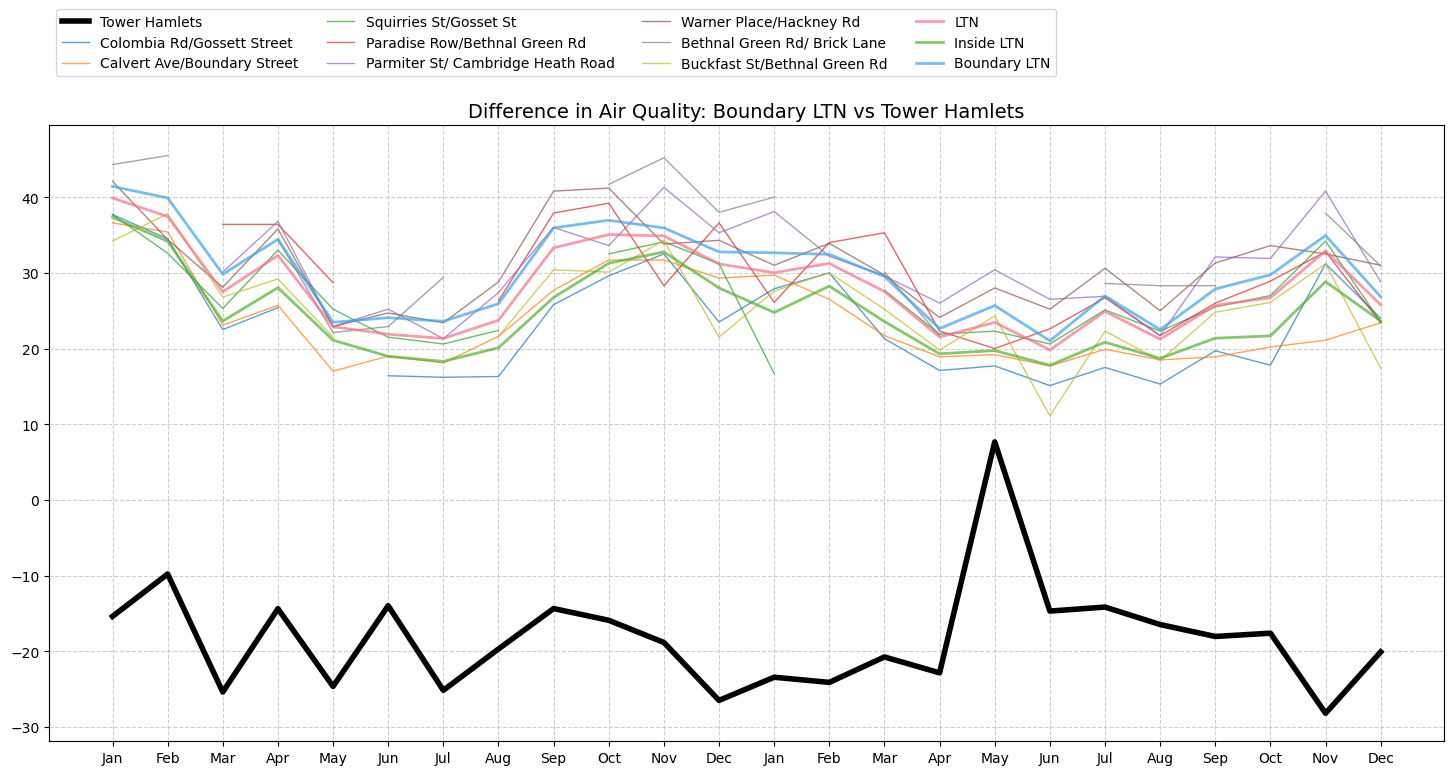

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(18, 8))
months = range(len(diff_th))
ax.plot(months, diff_th, alpha=1., lw=4, color='black', label='Tower Hamlets')
colors = sns.color_palette("tab10", len(ltn_locations))
for i, location in enumerate(ltn_locations):
    if location == 'Queensbridge Rd/Hackney Rd':
        continue
    diff_location, _, _ = get_diff(df_test, location)
    ax.plot(months, diff_location, alpha=0.7, lw=1, label=location, color=colors[i])

colors = sns.color_palette("husl", 3)
for i, location in enumerate(['LTN', 'Inside LTN', 'Boundary LTN']):
    diff_location, _, _ = get_diff(df_test, location)
    ax.plot(months, diff_location, alpha=0.7, lw=2, label=location, color=colors[i])
ax.set_title(f'Difference in Air Quality: {location} vs Tower Hamlets', fontsize=14)
ax.grid(True, linestyle='--', alpha=0.6)
ax.set_xticklabels(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'] * 2)
# ax.set_xticklabels(['Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
ax.set_xticks(months)
plt.legend(loc='upper left', bbox_to_anchor=(0., 1.2), fontsize=10, ncol=4)
plt.show()

In [15]:
html_table = """
<style type="text/css">
.center{text-align:center;vertical-align:center}
</style>
<table>
<thead>
  <tr>
    <th class=""></th>
    <th class="center">2018-2019<br>average</th>
    <th class="center"><span style="font-style:normal">2023-2024</span><br><span style="font-style:normal">average</span></th>
    <th class="center">Δ (%)</th>
    <th class="center">Δ (p-value)</th>
    <th class="center">Δ of Δ (p-value)</th>
  </tr>
</thead>
<tbody>
"""
location_map = {
    'LTN': 'Inside or boundary of Liveable Streets',
    'Inside LTN': 'Inside Liveable Streets',
    'Boundary LTN': 'Boundary of Liveable Streets',
    'Tower Hamlets': 'Rest of Tower Hamlets'
}
# for location in ['Inside LTN', 'Boundary LTN', 'LTN', 'Tower Hamlets']:
for location in ['Inside LTN', 'Boundary LTN', 'Tower Hamlets']:
  df_location = df_test[df_test['location'] == location]
  html_table += f"""
    <tr>
      <td class=""><b>{location_map[location]}</b></td>
      <td class="center">{df_location['before'].iloc[0]:.1f}</td>
      <td class="center">{df_location['after'].iloc[0]:.1f}</td>
      <td class="center">&#8595 {-df_location['relative_diff'].iloc[0] * 100:.1f}</td>
      <td class="center">{df_location['t-test'].iloc[0]:.1e}</td>
      <td class="center">{df_location['t-test wrt TH'].iloc[0]:.2f}</td>
    </tr>
  """
html_table += """
</tbody>
</table>
"""

print(html_table)


<style type="text/css">
.center{text-align:center;vertical-align:center}
</style>
<table>
<thead>
  <tr>
    <th class=""></th>
    <th class="center">2018-2019<br>average</th>
    <th class="center"><span style="font-style:normal">2023-2024</span><br><span style="font-style:normal">average</span></th>
    <th class="center">Δ (%)</th>
    <th class="center">Δ (p-value)</th>
    <th class="center">Δ of Δ (p-value)</th>
  </tr>
</thead>
<tbody>

    <tr>
      <td class=""><b>Inside Liveable Streets</b></td>
      <td class="center">47.2</td>
      <td class="center">24.5</td>
      <td class="center">&#8595 48.1</td>
      <td class="center">1.4e-16</td>
      <td class="center">0.02</td>
    </tr>
  
    <tr>
      <td class=""><b>Boundary of Liveable Streets</b></td>
      <td class="center">51.5</td>
      <td class="center">29.9</td>
      <td class="center">&#8595 40.9</td>
      <td class="center">2.2e-11</td>
      <td class="center">0.18</td>
    </tr>
  
    <tr>
      <td cl

In [17]:
html_table = """
<style type="text/css">
.center{text-align:center;vertical-align:center}
</style>
<table>
<thead>
  <tr>
    <th class=""></th>
    <th class="center">2018-2019<br>average</th>
    <th class="center"><span style="font-style:normal">2023-2024</span><br><span style="font-style:normal">average</span></th>
    <th class="center">Change (%)</th>
    <th class="center">Δ of Δ</th>
    <th class="center">p-value</th>
  </tr>
</thead>
<tbody>
"""

rows = ['Inside LTN', 'Boundary LTN', 'Tower Hamlets']
for locations_name, locations in zip(rows, [inside_ltn_locations, boundary_ltn_locations, ['Tower Hamlets']]):

  # html_table += f"""<tr> <td class=""><b>{locations_name}</b></td> <td></td> <td></td> <td></td> <td></td> <td></td> </tr>"""
  for location in [locations_name] + locations:
      html_table += '<tr> \n'
      
      bolded_name = f"<b>{location_map[location]}</b>" if location in rows else location
      if location in rows:

        html_table += '<tr style="border-bottom: 1px solid black"> \n'
      html_table += f'<td class="">{bolded_name}</td> \n' 
      location_df = df_test[df_test['location'] == location]
      mean_before = location_df.query('`test_period` == "before"')['aq'].mean()
      mean_after = location_df.query('`test_period` == "after"')['aq'].mean()
      mean_relative_change = -(mean_after - mean_before) / mean_before * 100
      t_test = location_df.query('`test_period` == "after"')['t-test'].mean()
      t_test_diff_of_diff_pval = location_df.query('`test_period` == "after"')['t-test wrt TH'].mean()
      t_test_diff_of_diff_stats = location_df.query('`test_period` == "after"')['t-test wrt TH stats'].mean()
      html_table += f'<td class="center">{mean_before:.1f}</td> \n'
      html_table += f'<td class="center">{mean_after:.1f}</td> \n'
      html_table += f'<td class="center">&#8595 {mean_relative_change:.1f}</td> \n'
      # html_table += f'<td class="center">{t_test:.1e}</td> \n'
      html_table += f'<td class="center">{t_test_diff_of_diff_stats:.1f}</td> \n'
      html_table += f'<td class="center">{t_test_diff_of_diff_pval:.3f}</td> \n'
      html_table += '</tr> \n'

      if location == 'Tower Hamlets':
        break

html_table += """
</tbody>
</table>
"""
print(html_table)


<style type="text/css">
.center{text-align:center;vertical-align:center}
</style>
<table>
<thead>
  <tr>
    <th class=""></th>
    <th class="center">2018-2019<br>average</th>
    <th class="center"><span style="font-style:normal">2023-2024</span><br><span style="font-style:normal">average</span></th>
    <th class="center">Change (%)</th>
    <th class="center">Δ of Δ</th>
    <th class="center">p-value</th>
  </tr>
</thead>
<tbody>
<tr> 
<tr style="border-bottom: 1px solid black"> 
<td class=""><b>Inside Liveable Streets</b></td> 
<td class="center">47.2</td> 
<td class="center">24.5</td> 
<td class="center">&#8595 48.1</td> 
<td class="center">-2.4</td> 
<td class="center">0.020</td> 
</tr> 
<tr> 
<td class="">Colombia Rd/Gossett Street</td> 
<td class="center">44.4</td> 
<td class="center">23.3</td> 
<td class="center">&#8595 47.6</td> 
<td class="center">-1.7</td> 
<td class="center">0.103</td> 
</tr> 
<tr> 
<td class="">Calvert Ave/Boundary Street</td> 
<td class="center">47.6<

In [ ]:
def process_yearly_mean(df, year):
    """ function taking a dataframe and year, returning a dataframe with the mean and adjusted mean of the year """
    # Find first row
    first_col = df.iloc[:, 0]
    column_row_index = first_col[first_col == "Site no"].index.tolist()[0]
    # Find last column
    column_row = df.iloc[column_row_index, :]
    column_end = column_row.to_list().index(f"Dec-{str(year)[2:]}")

    columns = df.iloc[column_row_index]
    df.columns = columns

    df = df.iloc[column_row_index+1:, 1:column_end+3]
    if 'Average' in df.columns:
        df = df.rename(columns={'Average': 'Annual\nmean'})
    if "Annualised & Bias Adjusted Average *" in df.columns:
        df = df.rename(columns={"Annualised & Bias Adjusted Average *": "Annualised & Bias Adjusted Average"})
    if "Annualised & Bias Adjusted Average \n*" in df.columns:
        df = df.rename(columns={"Annualised & Bias Adjusted Average \n*": "Annualised & Bias Adjusted Average"})
    df = df.drop(df.loc[:, 'Location':'Annual\nmean'].columns[1:-1], axis=1)

    df['Location'] = df['Location'].replace('Bethnal Grn Rd/ Brick Lane', 'Bethnal Green Rd/ Brick Lane')
    # df = df[df['Location'].isin(ltn_locations)]

    df['year'] = year
    
    return df

# Load yearly data, process and concatenate
year_range = range(2015, 2024 + 1)
dfs = []
for year in year_range:
    df = pd.read_csv(path_to_data.joinpath(f"{year}-Table 1.csv"))
    df = process_yearly_mean(df, year=year)
    dfs.append(df)
df = pd.concat(dfs, ignore_index=True)

# Group by 'year' and compute mean for the specified columns
# th_df = df.query('`Location` not in @ltn_locations').groupby(['year'])[['Annual\nmean', 'Annualised & Bias Adjusted Average']].mean().reset_index()
# th_df = df.query('`Location` not in @ltn_locations').groupby(['year'])[['year', 'Annual\nmean', 'Annualised & Bias Adjusted Average']].mean(numeric_only=True)
# th_df = df.query('`Location` not in @ltn_locations').groupby(['year'])[['Annual\nmean', 'Annualised & Bias Adjusted Average']].mean(numeric_only=True)#.reset_index()
# # .mean()#.reset_index()
# print(th_df)
# print(th_df.columns)
# th_df['Location'] = 'Tower Hamlets'
# # th_df = th_df[df.columns]
# th_df = th_df.sort_values(by='year')
# df = pd.concat([df, th_df], ignore_index=True)

# Choose which modality to create the table for
# column = "Annual\nmean"
column = "Annualised & Bias Adjusted Average"

# Create color map for data
min_value, max_value = 0, 80

def rgb2hex(r,g,b,a):
    return "#{:02x}{:02x}{:02x}".format(int(r*255),int(g*255),int(b*255)).upper()

# cmap = sns.color_palette("RdYlGn_r", as_cmap=True)

# Create a custom diverging colormap
from matplotlib.colors import LinearSegmentedColormap
colors = ["forestgreen", "white",  "orangered"]
cmap = LinearSegmentedColormap.from_list("custom_diverging", colors, N=256) # Create the colormap


html_table = """
<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-o5n3{background-color:#FFF;font-weight:bold;text-align:left;vertical-align:bottom}
.tg .tg-j6zm{font-weight:bold;text-align:left;vertical-align:bottom}
</style>
<table class="tg" style="width: 700px;">\n
<tr>\n
<thead>\n
<th class="tg-o5n3"><span style="font-weight:700;text-decoration:none;color:black;background-color:white"> </span></th>\n
"""
for year in year_range:
    text_year = str(year) if year != 2015 else f"{year}*"
    html_table += f'<th class="tg-o5n3"><span style="font-weight:700;text-decoration:none;color:black;background-color:white">{year}</span></th>\n'
html_table += '</tr>\n'
html_table += '</thead>\n'
html_table += '<tbody>\n'

for location in sorted(ltn_locations) + ['Tower Hamlets']:
# for location in ['Tower Hamlets']:
    html_table += '<tr>\n'
    html_table += f'  <td class="tg-j6zm">{location}</td>\n'
    for year in year_range:
        class_tg = "tg"
        values = df.query(f"Location == '{location}' and year == {year}")[column].values
        if len(values) == 1:
            value = round(float(values[0]), 1)
            cmap_value = (value - min_value) / (max_value - min_value)
            colour = rgb2hex(*cmap(cmap_value))
            style=f"background-color:{colour}"
            html_table += f'  <td class="{class_tg}" style="{style}"><span style="background-color:{colour}">{value}</span></td>\n'
        elif len(values) == 0:
            html_table += f'  <td class="{class_tg}"></td>\n'
        else:
            raise ValueError(f"Multiple values found for {location} in {year} for column {column}")
    html_table += '</tr>\n'
html_table += '</tbody>\n'
html_table += '</table>\n'

print(html_table)
# Copy paste the html table into observable entry


<style type="text/css">
.tg  {border-collapse:collapse;border-spacing:0;}
.tg td{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  overflow:hidden;padding:10px 5px;word-break:normal;}
.tg th{border-color:black;border-style:solid;border-width:1px;font-family:Arial, sans-serif;font-size:14px;
  font-weight:normal;overflow:hidden;padding:10px 5px;word-break:normal;}
.tg .tg-o5n3{background-color:#FFF;font-weight:bold;text-align:left;vertical-align:bottom}
.tg .tg-j6zm{font-weight:bold;text-align:left;vertical-align:bottom}
</style>
<table class="tg" style="width: 700px;">

<tr>

<thead>

<th class="tg-o5n3"><span style="font-weight:700;text-decoration:none;color:black;background-color:white"> </span></th>

<th class="tg-o5n3"><span style="font-weight:700;text-decoration:none;color:black;background-color:white">2015</span></th>
<th class="tg-o5n3"><span style="font-weight:700;text-decoration:none;color:black;background-color:white">2016